In [1850]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold, SequentialFeatureSelector, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, RFE 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import skew
import numpy as np
from pathlib import Path
import matplotlib.patches as mpatches
import joblib
import shap

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.prediction.aggregates.classifier import CLASSIFIER

# %matplotlib inline
# plt.style.use('ggplot')

# # set default color cycle
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [1769]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_small.csv')

In [1770]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [1771]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 135)

In [1772]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(103, 132)


In [1773]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(103, 132)
(103, 132)


In [1774]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [1775]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()
gaussian_scaler = StandardScaler()
non_gaussian_scaler = RobustScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)


# Fit the scaler to the dataframe and transform the dataframe
scaled_Y = pd.DataFrame(minmax_scaler.fit_transform(Y), columns=['P', 'E', 'R', 'M', 'A'])


In [1776]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

In [1777]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, scaled_Y, test_size=0.2, random_state=42)

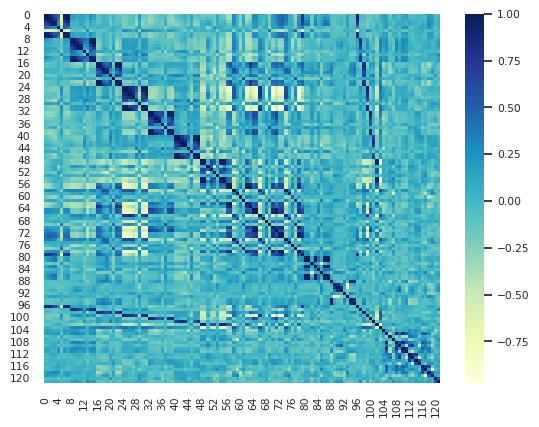

In [1778]:
plot_correlation_matrix(X_train)

In [1779]:
def get_selected_voting_features_combined(Y, X, filter_methods, wrapper_methods, k):
    #np.random.seed(1)
    
    feature_counts = np.zeros(X.shape[1])

    # Apply filter methods
    for _, method in filter_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        print(len(selected_i))
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1

    # Apply wrapper methods
    for _, method in wrapper_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
    
    # Get the indices of the top k features with the most counts
    #selected_features = np.argsort(feature_counts)[-k:]
    selected_features = np.where(feature_counts >= k)[0]
    print(np.sort(feature_counts))
    
    return selected_features

In [1780]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=8),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=8),
    'variance_threshold': VarianceThreshold(threshold=1.5),
    'select_percentile': SelectPercentile(f_regression, percentile=10),
    'select_fpr': SelectFpr(f_regression, alpha=0.15),
    'select_fdr': SelectFdr(f_regression, alpha=0.99),
    'select_fwe': SelectFwe(f_regression, alpha=1.0),
    #'rfe_regression': RFEC(LinearRegression(), n_features_to_select=8),
}

wrapper_methods = {
    #'sfs_regression': SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='forward', n_jobs=-1),
    #'sbs_regression': SequentialFeatureSelector(LinearRegression(), n_features_to_select=8, direction='backward', n_jobs=-1),
}


# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_combined(Y_train.iloc[:, i], X_train, filter_methods, wrapper_methods, k=4)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])


8
8
33
13
12
43
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4.
 5. 5.]
8
8
33
13
20
121
0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 5. 5.
 5. 5.]
8
8
33
13
27
114
2
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

In [1781]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    X_test_final = X_test.iloc[:, list(set(selected_features))]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)


P : ['Angry__Slope', 'Fear__max_count', 'Degree Centrality', 'Dominance__standard_deviation', 'Dominance__minimum', 'GazeDifference_Max', 'Velocity__median', 'Velocity__mean', 'Velocity__Slope']
E : ['Gazes_Mean', 'Gazes_Min', 'GazeDifference_Mean', 'GazeDifference_Min', 'Neutral__standard_deviation', 'Valence__median', 'Valence__mean', 'Valence__maximum', 'Sad__P_25', 'Valence__P_75']
R : ['Brightness__median', 'GazeDifference_Mean', 'Brightness__standard_deviation', 'GazeDifference_Max', 'Brightness__P_75', 'Velocity__median', 'Velocity__minimum', 'Velocity__P_25', 'Velocity__P_75']
M : ['Degree Centrality', 'Dominance__standard_deviation', 'Dominance__Slope', 'Dominance__P_25', 'GazeDifference_Mean', 'Sad__Slope', 'Happy__maximum', 'GazeDifference_Max', 'Valence__Slope']
A : ['Sad__max_count', 'Dominance__median', 'Dominance__mean', 'Dominance__P_25', 'Sad__median', 'Sad__mean', 'Valence__median', 'Sad__P_75', 'Valence__P_75']


In [1782]:
SAVE_DIR = Path("/home/moritz/Workspace/masterthesis/model/custom_models/univariate/small")

eval_metric = "mean_absolute_error"

In [1783]:
models_to_drop = ["MLPRegressor", "KNeighborsRegressor", "DecisionTreeRegressor", "SVR", "Lasso", "GradientBoostingRegressor"]

for name in models_to_drop:
    for i in range(len(MODELS)):
        if MODELS[i]["name"] == name:
            del MODELS[i]
            break
        
for model in MODELS:
    print(model["name"])

RandomForestRegressor
ExtraTreesRegressor
AdaBoostRegressor
LinearRegression
Ridge
ElasticNet
BayesianRidge
CatBoostRegressor
XGBRegressor


In [1784]:
results_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR / perma_dim
    X_train = X_final["train"]
    search = HyperparaSearch(models=MODELS, metrics=["mean_absolute_error"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")  
    results = search.run(X_train, Y_train[perma_dim], save=True)
    results_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for RandomForestRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/RandomForestRegressor.joblib
Models for ExtraTreesRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ExtraTreesRegressor.joblib
Models for AdaBoostRegressor saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/AdaBoostRegressor.joblib
Models for LinearRegression saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/LinearRegression.joblib
Models for Ridge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/Ridge.joblib
Models for ElasticNet saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/ElasticNet.joblib
Models for BayesianRidge saved to /home/moritz/Workspace/masterthesis/model/custom_models/univariate/small/P/BayesianRidge.joblib
Models for CatBoostRegressor saved to /home/moritz/

In [1785]:
best_models = {}

for perma_dim, results in results_dict.items():
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    # print(perma_dim)
    # print(f"Best model: {best_model['name']}")
    # print(f"Best params: {best_model['params']}")
    # print(f"Best Score: {best_model['score']}")
    best_models[perma_dim] = best_model['name']

In [1786]:
def load_best_model(file_path: Path):

    models = {}

    if file_path.is_file():
        model = joblib.load(file_path)

        models[str(file_path.stem)] = model

    return models

In [1787]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR / perma_dim / (best_models[perma_dim] + ".joblib")
    models = load_best_model(models_path)
    perma_models[perma_dim] = models

In [1788]:
# perma_models = {}

# for perma_dim in ["P", "E", "R", "M", "A"]:
#     models_path = SAVE_DIR / perma_dim
#     models = load_models(models_path)
#     perma_models[perma_dim] = models

In [1789]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def generate_predictions(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate mean squared error and mean absolute error
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        results[model_name] = {"mae": mae, "mse": mse, "y_pred": y_pred}
    return results

In [1790]:
def generate_shap_values(models, X):
    for model_name, mae_grid_search in models.items():
        model = mae_grid_search[0].best_estimator_
        print(model_name)

        if model_name in ["ElasticNet", "Lasso", "Ridge", "LinearRegression", "BayesianRidge"]:
            explainer = shap.LinearExplainer(model, X, feature_names=X.columns)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X)
        elif model_name in ["AdaBoostRegressor"]:
            explainer = shap.SamplingExplainer(model.predict, X)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X)
        else:
            explainer = shap.Explainer(model, feature_names=X.columns)
            shap_values = explainer(X)
            shap.summary_plot(shap_values, X)


P
CatBoostRegressor


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


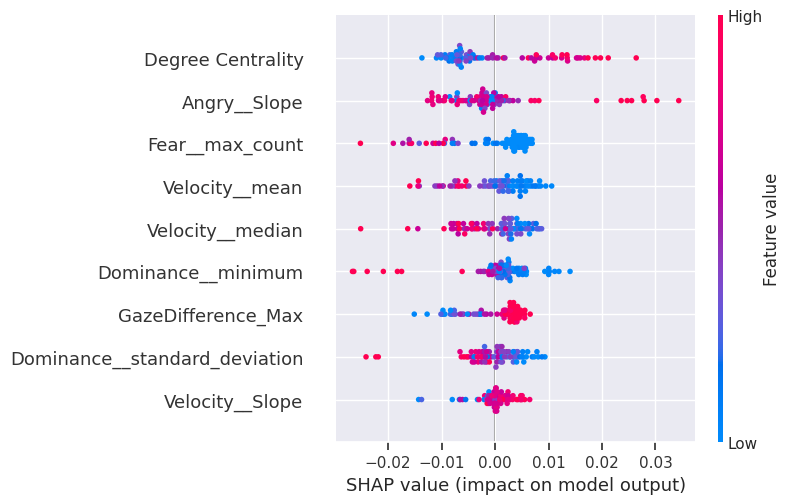

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names


E
AdaBoostRegressor


  0%|          | 0/82 [00:00<?, ?it/s]X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
X does not have valid feature names, but AdaBoostRegressor was fitted wi

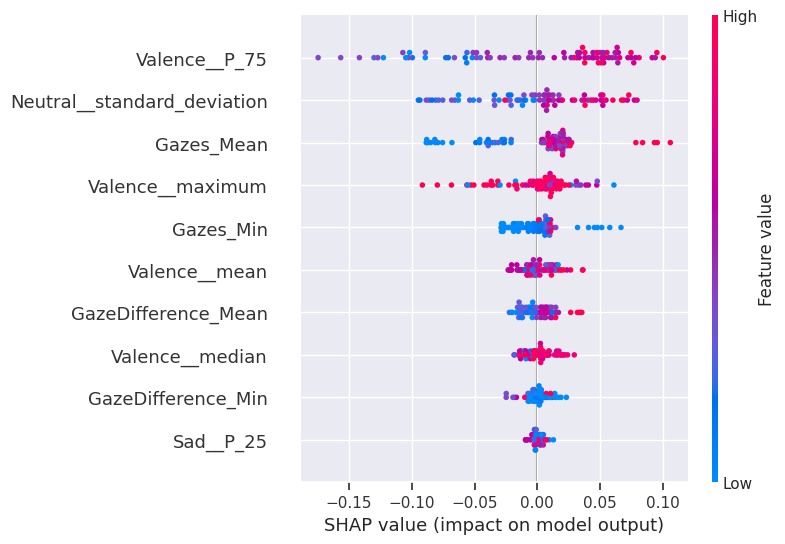

R
BayesianRidge


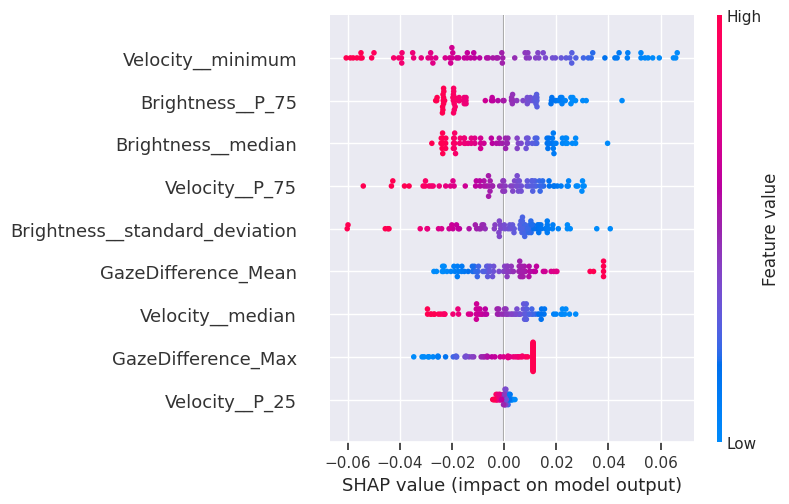

M
ElasticNet


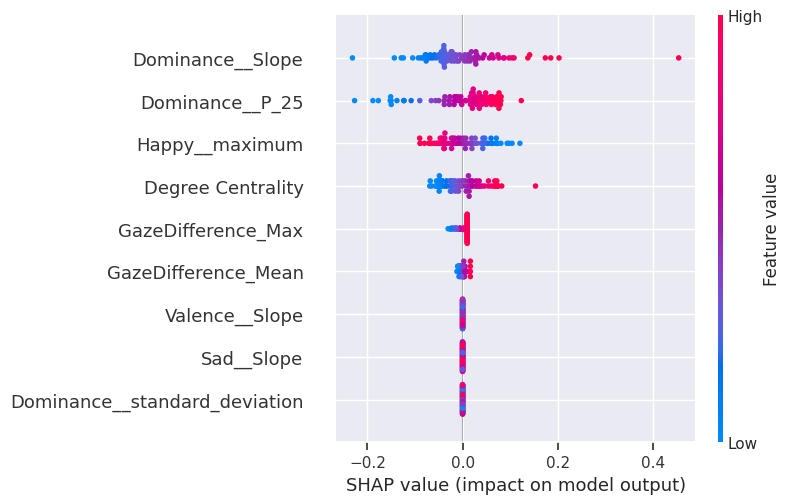

A
BayesianRidge


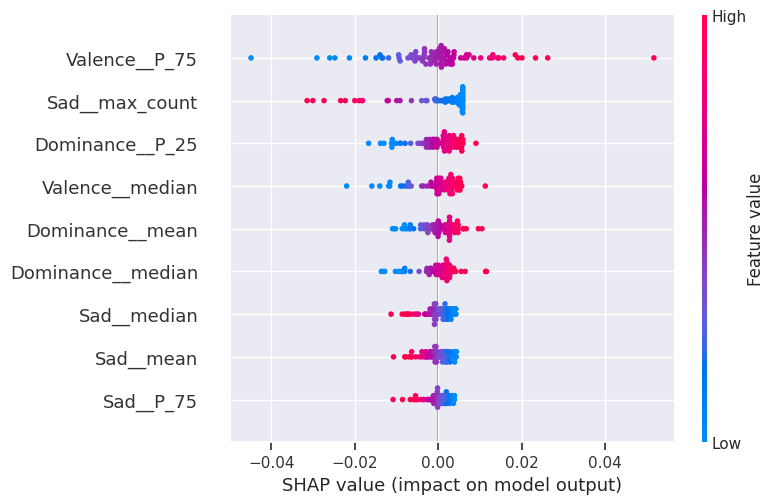

In [1791]:
for dim, models in perma_models.items():
    print(dim)
    X_test = feature_sets[dim]["train"]
    generate_shap_values(models, X_test)

In [1792]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results
    # for model_name, result in results.items():
    #     print(f"{dim} - {model_name}: MAE - {result['mae']}, MSE - {result['mse']}")
    

In [1793]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["mae"] < curr_mae:
            curr_mae = results[model]["mae"]
            best_results[dim] = {"model": model, "mae": results[model]["mae"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'CatBoostRegressor', 'mae': 0.162265071923784, 'preds': array([0.64263363, 0.67736806, 0.64701745, 0.65096031, 0.65429439,
       0.68639163, 0.63279904, 0.6308474 , 0.6294556 , 0.6510299 ,
       0.61253275, 0.63870699, 0.6495132 , 0.61451515, 0.65083786,
       0.62236546, 0.63558066, 0.64069066, 0.64623658, 0.64035105,
       0.63172708])}, 'E': {'model': 'AdaBoostRegressor', 'mae': 0.2050229154194805, 'preds': array([0.46875   , 0.56944444, 0.5375    , 0.6171875 , 0.6171875 ,
       0.7025    , 0.46875   , 0.79714286, 0.60416667, 0.69      ,
       0.44666667, 0.52068966, 0.58333333, 0.6       , 0.38181818,
       0.54583333, 0.6171875 , 0.37391304, 0.65555556, 0.53636364,
       0.68913043])}, 'R': {'model': 'BayesianRidge', 'mae': 0.13145295191307887, 'preds': array([0.68925716, 0.80386443, 0.73374387, 0.67135511, 0.8045724 ,
       0.76497896, 0.78332067, 0.82924224, 0.69391308, 0.72238094,
       0.57338402, 0.69675556, 0.75034005, 0.64270528, 0.72676561,
      

In [1794]:
best_feats_dict = {}

for dim, results in results_dict.items():
    best_feats_dict[dim] = {model[0]['name']: {"feat_imp": model[0]['best_feats'], "score": model[0]["score"]}  for model in results}

best_feats_dict_dim = {}
    
for dim in ['P', 'E', 'R', 'M', 'A']:
    model = best_results[dim]["model"]
    feat_imp = abs(best_feats_dict[dim][model]["feat_imp"])
    best_feats_dict_dim[dim] = feat_imp

best_feats_dict_dim


{'P': array([17.22181159, 10.58161939, 14.0088469 ,  8.98411537, 13.11171898,
         6.69659437, 11.53372224, 10.88974745,  6.97182371]),
 'E': array([0.13608584, 0.07298846, 0.0573693 , 0.06003071, 0.15893099,
        0.05603589, 0.0863722 , 0.1549103 , 0.03156205, 0.18571427]),
 'R': array([0.01696607, 0.01880213, 0.02105841, 0.02228938, 0.01839361,
        0.01448815, 0.03282781, 0.00201336, 0.02121403]),
 'M': array([0.0597263 , 0.        , 0.0721702 , 0.07035442, 0.00805431,
        0.        , 0.05185876, 0.01952891, 0.        ]),
 'A': array([0.00628783, 0.00538932, 0.00461337, 0.00516828, 0.00375484,
        0.00346524, 0.00412247, 0.00341019, 0.00832497])}

In [1795]:
ranked_feats_dict = {}

for (dim, feat_imp_vals), (dim, X_final) in zip(best_feats_dict_dim.items(), feature_sets.items()):
    # Map the feature importance values with the feature list using a dictionary comprehension
    column_names = X_final["train"].columns.tolist()
    feat_imp_map = {column_names[i]: feat_imp_vals[i] for i in range(len(column_names))}
    # Rank the features by their importance value in descending order
    ranked_feats = sorted(feat_imp_map.items(), key=lambda x: x[1], reverse=True)
    ranked_feats_dict[dim] = ranked_feats


FixedFormatter should only be used together with FixedLocator


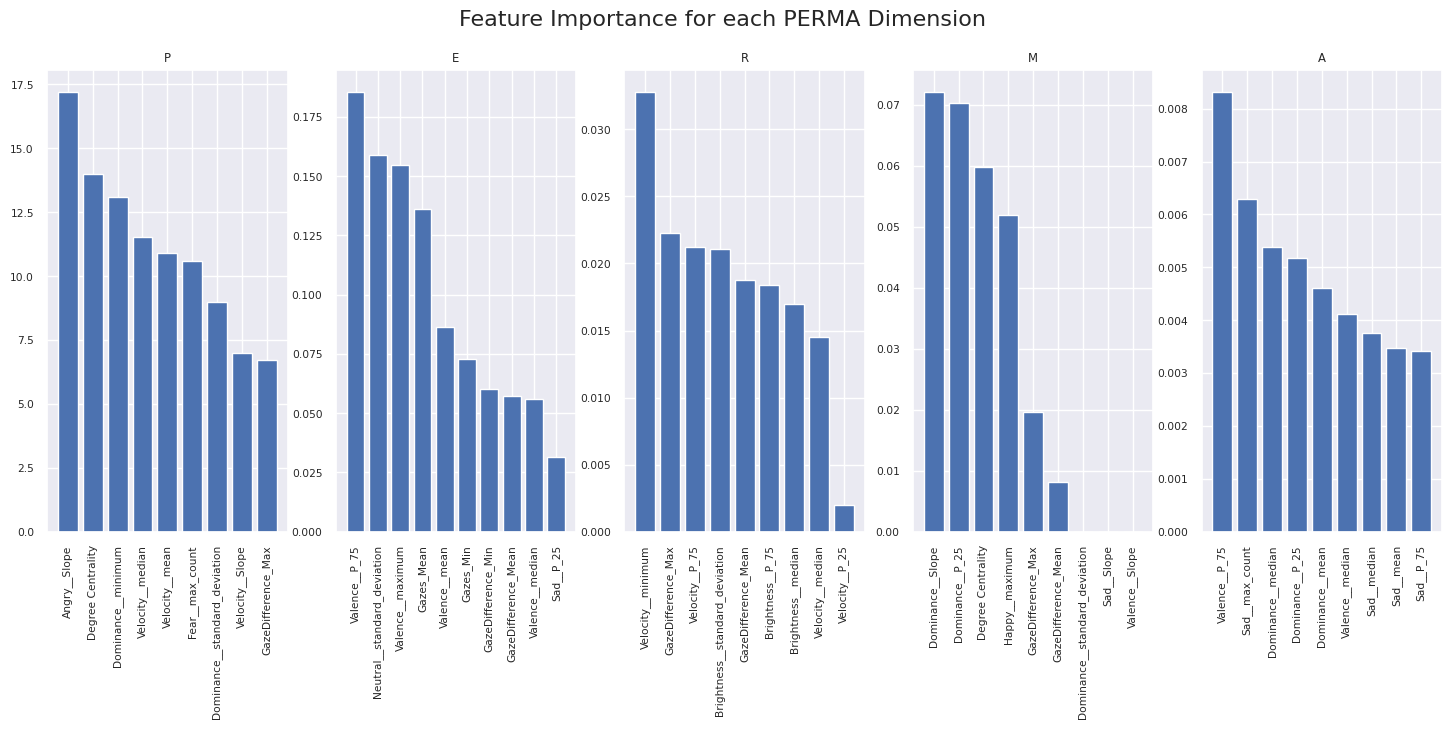

In [1796]:
#Separate the feature names and importance scores for each dimension PERMA
P_features, P_scores = zip(*ranked_feats_dict["P"])
E_features, E_scores = zip(*ranked_feats_dict["E"])
R_features, R_scores = zip(*ranked_feats_dict["R"])
M_features, M_scores = zip(*ranked_feats_dict["M"])
A_features, A_scores = zip(*ranked_feats_dict["A"])


#Create a bar plot for each dimension PERMA
fig, axs = plt.subplots(1, 5, figsize=(18, 6))
axs[0].bar(P_features, P_scores)
axs[0].set_title("P")
axs[1].bar(E_features, E_scores)
axs[1].set_title("E")
axs[2].bar(R_features, R_scores)
axs[2].set_title("R")
axs[3].bar(M_features, M_scores)
axs[3].set_title("M")
axs[4].bar(A_features, A_scores)
axs[4].set_title("A")

#Set common axis labels and title
fig.suptitle("Feature Importance for each PERMA Dimension", fontsize=16)
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [1797]:
# Baseline:
Y_baseline = np.full_like(Y_test, Y_test.mean(axis=0).transpose())
mae_baseline = mean_absolute_error(Y_test, Y_baseline, multioutput='raw_values')

print(f"Baseline MAE for each dimension: {mae_baseline}")

Baseline MAE for each dimension: [0.16439909 0.20816327 0.14739229 0.20272109 0.1462585 ]


Text(0, 0.5, 'MAE scores')

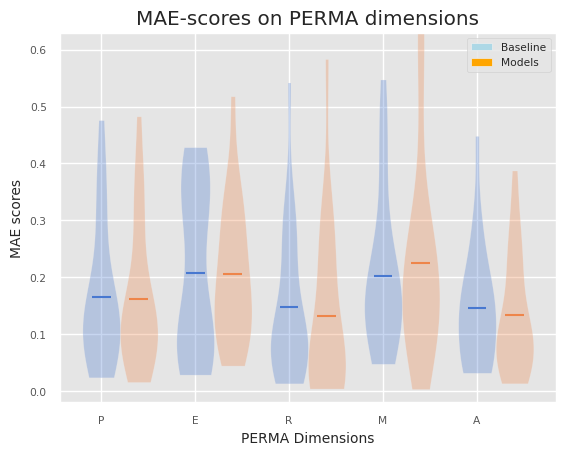

In [1859]:
# Calculate the errors between the actual values and the baseline predictions
baseline_errors = abs(Y_test - Y_baseline)

# Calculate the errors for each model and each dimension
model_errors = pd.DataFrame()

# Calculate the errors for each model and each dimension
for dim in ['P', 'E', 'R', 'M', 'A']:
    err = abs(Y_test[dim] - best_results[dim]['preds'])
    errors = pd.DataFrame({'errors': err})
    model_errors = pd.concat([model_errors, errors], axis=1)

# Concatenate baseline and model errors
all_errors = [baseline_errors, model_errors]

# Create a combined boxplot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
colors = ['lightblue', 'orange']
labels = ['Baseline', 'Models']

for i, error_df in enumerate(all_errors):
    position = np.arange(1, len(error_df.columns) + 1) + (i * 0.4)
    #ax.boxplot(error_df, positions=position, widths=0.4, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black'))
    ax.violinplot(error_df, positions=position, widths=0.4, showmedians=False, showextrema=False, showmeans=True)

# Define the labels for the x-axis
perma = ['P', 'E', 'R', 'M', 'A']

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(1, len(perma) + 1))
ax.set_xticklabels(perma)
ax.set_ylim(-0.02, 0.63)

# Create the legend patches and labels
patches = [mpatches.Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# Add the legend to the plot
#ax.legend()
ax.set_title('MAE-scores on PERMA dimensions')
ax.legend(handles=patches, loc='upper right')
ax.set_xlabel('PERMA Dimensions')
ax.set_ylabel('MAE scores')

(0.0, 0.3)

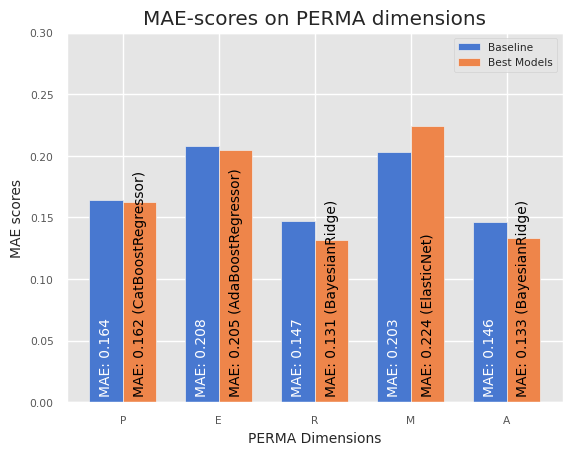

In [1853]:

# Print the best model for each PERMA dimension
best_mae_values = [v['mae'] for v in best_results.values()]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
ax.bar(np.arange(len(perma_dimensions)), mae_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_mae_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimensions')

# Set the y-axis label and limits
ax.set_ylabel('MAE scores')
ax.set_ylim([0, max(np.max(mae_baseline), np.max(best_mae_values))*1.1])

# Add the model names and MAE values above each bar
for i, v in enumerate(mae_baseline):
    ax.text(i, 0.005, f"MAE: {v:.3f}", rotation=90, ha='center', va='bottom', fontsize=10, color='white')
    ax.text(i+bar_width, 0.005, f"MAE: {best_mae_values[i]:.3f} ({best_results[perma_dimensions[i]]['model']})", rotation=90, ha='center', va='bottom', fontsize=10, color='black')

# Add a legend and title
ax.legend()
ax.set_title('MAE-scores on PERMA dimensions')
ax.set_ylim([0, 0.3])

In [1800]:
Y_pred = pd.DataFrame()

for dim in ['P', 'E', 'R', 'M', 'A']:
    err = best_results[dim]['preds']
    errors = pd.DataFrame({dim: err})
    Y_pred = pd.concat([Y_pred, errors], axis=1)

# Unscale the data back to the original scale
Y_preds = pd.DataFrame(minmax_scaler.inverse_transform(Y_pred), columns=['P', 'E', 'R', 'M', 'A'])
Y_tests = pd.DataFrame(minmax_scaler.inverse_transform(Y_test), columns=['P', 'E', 'R', 'M', 'A'])
Y_baselines = pd.DataFrame(minmax_scaler.inverse_transform(Y_baseline), columns=['P', 'E', 'R', 'M', 'A'])

In [1801]:
Y_baseline_df = pd.DataFrame(Y_baseline, columns=['P', 'E', 'R', 'M', 'A'])

print(Y_pred.min())
print(Y_pred.max())
print(Y_test.min())
print(Y_test.max())

P    0.612533
E    0.373913
R    0.573384
M    0.296793
A    0.527263
dtype: float64
P    0.686392
E    0.797143
R    0.829242
M    0.895909
A    0.762788
dtype: float64
P    0.166667
E    0.200000
R    0.166667
M    0.000000
A    0.250000
dtype: float64
P    1.0
E    1.0
R    1.0
M    1.0
A    1.0
dtype: float64


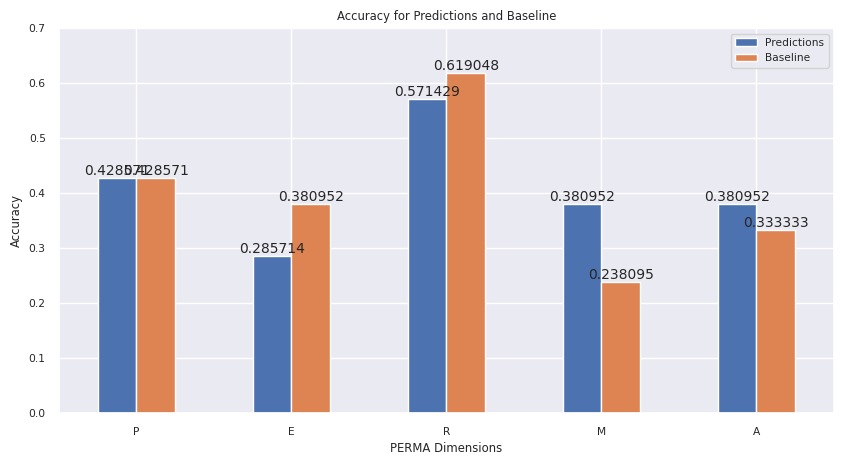

In [1802]:
# Define the bins and labels
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

# bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# Apply the binning
actual_values_bins = Y_test.apply(pd.cut, bins=bins, labels=labels)
predictions_bins = Y_pred.apply(pd.cut, bins=bins, labels=labels)
baseline_bins = Y_baseline_df.apply(pd.cut, bins=bins, labels=labels)

# Reset the indices of both DataFrames
actual_values_bins.reset_index(drop=True, inplace=True)
predictions_bins.reset_index(drop=True, inplace=True)
baseline_bins.reset_index(drop=True, inplace=True)

# Calculate the accuracy for each column
accur_preds = (actual_values_bins == predictions_bins).mean()
accur_baseline = (actual_values_bins == baseline_bins).mean()

# Combine accuracy values into a single DataFrame
accuracy_df = pd.DataFrame({'Predictions': accur_preds, 'Baseline': accur_baseline})

# Plot the accuracy values for predictions and baseline
ax = accuracy_df.plot(kind='bar', figsize=(10, 5))
plt.title('Accuracy for Predictions and Baseline')
plt.xlabel('PERMA Dimensions')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.ylim(0, 0.7)
plt.legend()

# Annotate values on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

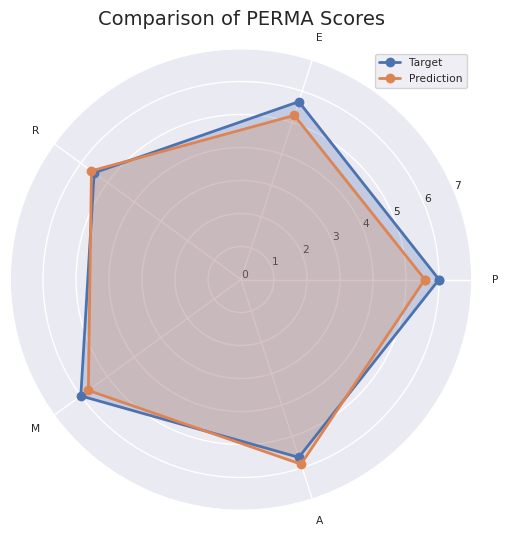

In [1803]:
# Define the labels for the radar plots
labels = ['P', 'E', 'R', 'M', 'A']

# Create the figure and subplot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Loop over each row of Y_tests and Y_preds
for i in [np.random.randint(0, len(Y_tests))]:
    # Define the data for the radar plot
    data1 = Y_tests.iloc[i].values
    data2 = Y_preds.iloc[i].values
    #data3 = Y_baselines.iloc[i].values

    # Define the angle for each label
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    # Close the plot
    data1 = np.concatenate((data1, [data1[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    data2 = np.concatenate((data2, [data2[0]]))
    #data3 = np.concatenate((data3, [data3[0]]))

    # Plot the radar plot
    ax.plot(angles, data1, 'o-', linewidth=2, label=f'Target')
    ax.fill(angles, data1, alpha=0.25)
    ax.plot(angles, data2, 'o-', linewidth=2, label=f'Prediction')
    ax.fill(angles, data2, alpha=0.25)
    #ax.plot(angles, data3, 'o-', linewidth=2, label=f'Baseline')
    #ax.fill(angles, data3, alpha=0.25)

# Set the labels
ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
plt.yticks(np.arange(0, 7.1, 1.0))
plt.ylim(0, 7)
plt.title('Comparison of PERMA Scores', fontsize=14)
plt.legend()